## Классификация изображений

In [ ]:
# !pip install wandb
# !pip3 install pytorch_lightning torchmetrics

# !pip install rich
# !pip install timm

[Документация библиотеки `pytorch_lightning`](https://lightning.ai/docs/pytorch/stable/)

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
# from tqdm import tqdm
from tqdm.notebook import tqdm
from rich import print
import timm

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

In [ ]:
# !wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

#### Подготовка данных

[Датасет](https://yadi.sk/d/BNR41Vu3y0c7qA): 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы от 0 до 199. Структура датасета - директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директории, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

In [ ]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5

    return mean, std

Правильная нормализация данных при создании: [гайд](https://www.pluralsight.com/guides/image-classification-with-pytorch).

In [ ]:
batch_size = 128

train_transform = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

base_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)

base_dataloader = DataLoader(base_dataset, batch_size=batch_size, shuffle=True)

get_mean_std(base_dataloader)

  0%|          | 0/782 [00:00<?, ?it/s]

(tensor([0.4802, 0.4481, 0.3975]), tensor([0.2764, 0.2688, 0.2816]))

In [ ]:
seed_everything(123456)

# аугментации при помощи модуля `torchvision.transforms`
train_transform = transforms.Compose(
        [
            #transforms.RandomRotation(45),
            #transforms.RandomVerticalFlip(),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomPerspective(),
            transforms.RandAugment(num_ops=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2688, 0.2816)),
        ]
)
val_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2688, 0.2816)),
        ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

[Документация `torchvision.transforms`](https://pytorch.org/vision/main/transforms.html)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed

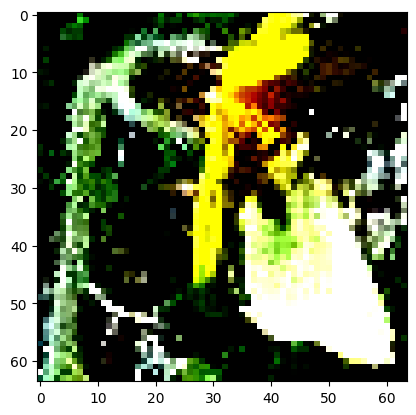

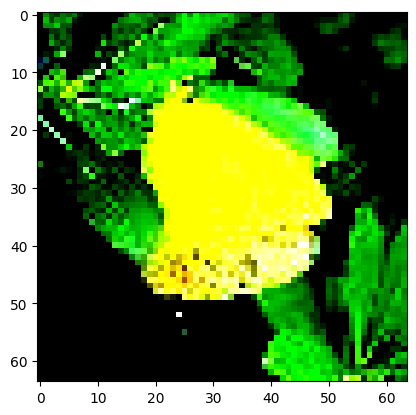

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

#### 1. Accuracy **на валидации $\geq$ 0.44** без использования предобученных моделей и ресайза картинок

**Модель** (импорт не предобученной сети)

In [ ]:
seed_everything(123456)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model("resnest14d", pretrained=False, num_classes=200).to(device)
model_name = "resnest14d"
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

Другой вариант - документация по возможным моделям и как их можно импортировать: [модуль torchvision.models](https://pytorch.org/vision/stable/models.html).

**Тренировочный цикл**

Реализация собственного пайплайна

In [ ]:
# import wandb

# wandb.login()

In [ ]:
seed_everything(123456)

epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4) # расписание на learning rate

In [ ]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader):

    # wandb.init(
    #     project="02_CV_1",
    #     config={
    #         "epochs": epochs,
    #         "batch_size": batch_size,
    #         "device": device,
    #         "model_name": model_name,
    #         "augs": train_transform,
    #         "lr": learning_rate,
    #         "optimizer": optimizer
    #     }
    # )

    best_model = None
    best_loss = 1e3

    # Train
    for epoch in range(1, epochs + 1):

        print(f"\n[bold bright_white]Train epoch {epoch}/{epochs}[/bold bright_white]")   # для красоты

        train_loss = 0
        train_acc = 0

        for (inputs, labels) in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            _, preds = torch.max(output, 1)   # беру наиболее вероятный класс

            loss = criterion(output, labels)
            acc = torch.sum(preds == labels.data)   # считаю не accuracy в чистом виде, а просто количество верных ответов в батче (без усреднения)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * inputs.size(0)    # лосс также считаю неусредненную
            train_acc += acc.item()

        train_loss_per_epoch = train_loss / len(train_dataset)    # тут уже усредняю лосс и accuracy по всему датасету на эпохе
        train_accuracy_per_epoch = train_acc / len(train_dataset)

        print()

        # Validation
        # Валидация для своевременного трека ошибок
        val_loss = 0
        val_acc = 0

        print(f"[bold bright_white]Validation epoch {epoch}/{epochs} [/bold bright_white]")

        model.eval()
        with torch.no_grad():
          for (inputs, labels) in tqdm(val_dataloader):
              inputs = inputs.to(device)
              labels = labels.to(device)

              output = model(inputs)
              _, preds = torch.max(output, 1)

              loss = criterion(output, labels)
              acc = torch.sum(preds == labels.data)

              val_loss += loss.item() * inputs.size(0)
              val_acc += acc.item()

        val_loss_per_epoch = val_loss / len(val_dataset)
        val_accuracy_per_epoch = val_acc / len(val_dataset)

        # сохраняю лучшую модель
        if val_loss_per_epoch < best_loss:
              best_model = model
              best_loss = val_loss_per_epoch
              best_accuracy = val_accuracy_per_epoch
              torch.save(best_model, "best_model.pt")
              print()
              print(f"Сохранение лучшей модели с Accuracy = {val_accuracy_per_epoch}, Val_loss = {val_loss_per_epoch}")

        scheduler.step()

        # # загружаю в wandb для сохранения эксперимента
        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": train_loss_per_epoch,
        #     "train_accuracy": train_accuracy_per_epoch,
        #     "val_loss": val_loss_per_epoch,
        #     "val_accuracy": val_accuracy_per_epoch,
        #     "best_loss": best_loss,
        #     "best_accuracy": best_accuracy,
        #     "lr": scheduler.get_last_lr()[-1]
        # })

        print()

        print(f"Epoch = [bold red]{epoch}/{epochs}[/bold red] | Train_loss = [bold yellow]{train_loss_per_epoch:.5f} [/bold yellow] \
    | Accuracy_train = [bold yellow]{train_accuracy_per_epoch:.5f}[/bold yellow] \
    | Val_loss = [bold green]{val_loss_per_epoch:.5f}[/bold green] | Accuracy_val = [bold green]{val_accuracy_per_epoch:.5f}[/bold green]")

Model Checkpointing - сохранение прогресса (модели):
- [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
- [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
seed_everything(123456)

train(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Train epoch 1/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 1/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.1556, Val_loss = 4.276061550521851

Epoch = 1/20 | Train_loss = 4.74143      | Accuracy_train = 0.07690     | Val_loss = 4.27606 | Accuracy_val = 
0.15560

Train epoch 2/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 2/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.2034, Val_loss = 4.0164637355804444

Epoch = 2/20 | Train_loss = 4.43006      | Accuracy_train = 0.12560     | Val_loss = 4.01646 | Accuracy_val = 
0.20340

Train epoch 3/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 3/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.2548, Val_loss = 3.8252807746887205

Epoch = 3/20 | Train_loss = 4.10813      | Accuracy_train = 0.18740     | Val_loss = 3.82528 | Accuracy_val = 
0.25480

Train epoch 4/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 4/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.2849, Val_loss = 3.7204891136169436

Epoch = 4/20 | Train_loss = 3.93605      | Accuracy_train = 0.22808     | Val_loss = 3.72049 | Accuracy_val = 
0.28490

Train epoch 5/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 5/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.3091, Val_loss = 3.608252374267578

Epoch = 5/20 | Train_loss = 3.79588      | Accuracy_train = 0.26175     | Val_loss = 3.60825 | Accuracy_val = 
0.30910

Train epoch 6/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 6/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.3352, Val_loss = 3.5275253368377686

Epoch = 6/20 | Train_loss = 3.67277      | Accuracy_train = 0.29104     | Val_loss = 3.52753 | Accuracy_val = 
0.33520

Train epoch 7/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 7/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.3686, Val_loss = 3.385555699157715

Epoch = 7/20 | Train_loss = 3.55546      | Accuracy_train = 0.32224     | Val_loss = 3.38556 | Accuracy_val = 
0.36860

Train epoch 8/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 8/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.3782, Val_loss = 3.3664242736816408

Epoch = 8/20 | Train_loss = 3.45193      | Accuracy_train = 0.34718     | Val_loss = 3.36642 | Accuracy_val = 
0.37820

Train epoch 9/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 9/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.3867, Val_loss = 3.341912309265137

Epoch = 9/20 | Train_loss = 3.34437      | Accuracy_train = 0.37528     | Val_loss = 3.34191 | Accuracy_val = 
0.38670

Train epoch 10/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 10/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4106, Val_loss = 3.2678570259094237

Epoch = 10/20 | Train_loss = 3.24852      | Accuracy_train = 0.40106     | Val_loss = 3.26786 | Accuracy_val = 
0.41060

Train epoch 11/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 11/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.429, Val_loss = 3.1943644260406496

Epoch = 11/20 | Train_loss = 3.15050      | Accuracy_train = 0.42769     | Val_loss = 3.19436 | Accuracy_val = 
0.42900

Train epoch 12/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 12/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4321, Val_loss = 3.1911346229553224

Epoch = 12/20 | Train_loss = 3.06362      | Accuracy_train = 0.44990     | Val_loss = 3.19113 | Accuracy_val = 
0.43210

Train epoch 13/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 13/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4416, Val_loss = 3.1714724380493164

Epoch = 13/20 | Train_loss = 2.97827      | Accuracy_train = 0.47547     | Val_loss = 3.17147 | Accuracy_val = 
0.44160

Train epoch 14/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 14/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4467, Val_loss = 3.1689165519714355

Epoch = 14/20 | Train_loss = 2.89816      | Accuracy_train = 0.50061     | Val_loss = 3.16892 | Accuracy_val = 
0.44670

Train epoch 15/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 15/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4562, Val_loss = 3.1497179290771484

Epoch = 15/20 | Train_loss = 2.82810      | Accuracy_train = 0.51963     | Val_loss = 3.14972 | Accuracy_val = 
0.45620

Train epoch 16/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 16/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch = 16/20 | Train_loss = 2.75839      | Accuracy_train = 0.54212     | Val_loss = 3.15991 | Accuracy_val = 
0.45560

Train epoch 17/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 17/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch = 17/20 | Train_loss = 2.70069      | Accuracy_train = 0.56171     | Val_loss = 3.15666 | Accuracy_val = 
0.45990

Train epoch 18/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 18/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.4676, Val_loss = 3.1372209869384764

Epoch = 18/20 | Train_loss = 2.65229      | Accuracy_train = 0.57615     | Val_loss = 3.13722 | Accuracy_val = 
0.46760

Train epoch 19/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 19/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch = 19/20 | Train_loss = 2.61054      | Accuracy_train = 0.59218     | Val_loss = 3.13729 | Accuracy_val = 
0.46600

Train epoch 20/20

  0%|          | 0/782 [00:00<?, ?it/s]

Validation epoch 20/20 

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch = 20/20 | Train_loss = 2.58596      | Accuracy_train = 0.59979     | Val_loss = 3.14947 | Accuracy_val = 
0.46670

**Валидация результатов**

In [ ]:
def evaluate_task(model, test_dataloader, test_dataset, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for (images, labels) in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            output = model(images)
            _, preds = torch.max(output, 1)
            acc_batch = torch.sum(preds == labels.data)
        accuracy += acc_batch
    accuracy = accuracy.item() / len(test_dataset)
    return accuracy

In [ ]:
model = torch.load("best_model.pt", map_location=torch.device(device))  # загрузка сохраненной модели

accuracy = evaluate_task(model, val_dataloader, val_dataset)
print(f"Accuracy {accuracy}")

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy 0.4676

In [ ]:
# # другой вариант - с лайтнингом (обучение на одной эпохе чисто для проверки, что все работает)
# from torchmetrics import functional

# # модель
# class MyNet(torch.nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.num_classes = num_classes
#         self.model = timm.create_model("resnest14d", pretrained=False, num_classes=self.num_classes)
#         self.loss_func = torch.nn.CrossEntropyLoss(label_smoothing=0.15)
#         self.targets = torch.Tensor()
#         self.preds = torch.Tensor()

#     def _forward(self, x):
#         # runs the Neural Network
#         x = self.model(x)
#         return x

#     def forward(self, images, target=None):
#         output = self._forward(images)

#         # get accuracy score and save it to self.accuracy
#         if target is not None:
#             loss = self.loss_func(output, target)

#             self.targets = torch.cat((self.targets, target.cpu()), 0)
#             pred = torch.argmax(output, dim=-1)
#             self.preds = torch.cat((self.preds, pred.cpu()), 0)
#             self.accuracy = functional.accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=self.num_classes)

#         return loss if target is not None else output

#     def get_accuracy(self, reset=False):
#         if reset:
#             self.targets = torch.Tensor()
#             self.preds = torch.Tensor()
#         return self.accuracy

# # тренировочный класс lightning
# class MyModule(pl.LightningModule):
#     def __init__(self, model, learning_rate):
#         super().__init__()
#         self.model = model
#         self.learning_rate = learning_rate

#     def forward(self, x):
#         result = self.model(x)

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4)
#         return ([optimizer], [scheduler])

#     def training_step(self, train_batch, batch_idx):
#         images, target = train_batch
#         loss = self.model(images, target)
#         accuracy = self.model.get_accuracy()
#         self.log("train_loss", loss, prog_bar=True)
#         self.log("train_accuracy", accuracy, prog_bar=True)
#         return loss

#     def validation_step(self, val_batch, batch_idx):
#         images, target = val_batch
#         loss = self.model(images, target)
#         accuracy = self.model.get_accuracy(reset=True)
#         self.log("val_loss", loss, prog_bar=True)
#         self.log("val_accuracy", accuracy, prog_bar=True)

# # сохранение лучшей модели
# class ModelSaver(pl.callbacks.ModelCheckpoint):
#     def on_save_checkpoint(self, trainer, pl_module, checkpoint):
#         torch.save(pl_module.model, os.path.join("model.ckpt"))

# # функция для проверки
# def evaluate_task_pl(model, test_dataloader, device="cuda:0"):
#     model = model.to(device)
#     model.eval()
#     accuracy = 0.0
#     for images, labels in tqdm(test_dataloader):
#         images, labels = images.to(device), labels.to(device)
#         with torch.no_grad():
#             loss = model(images, labels)
#             acc_batch = model.get_accuracy(reset=True)
#         accuracy += acc_batch
#     accuracy = accuracy / len(test_dataloader)
#     return accuracy

# # обучение
# seed_everything(123456)

# wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_pl = MyNet(num_classes=200).to(device)
# module = MyModule(model_pl, learning_rate=1e-3)

# checkpoint_callback = ModelSaver(monitor="val_loss", mode="min")
# trainer = pl.Trainer(logger=wandb_logger, accelerator='auto', max_epochs=1, callbacks=[checkpoint_callback])
# trainer.fit(module, train_dataloader, val_dataloader)

# model_pl.load_state_dict(torch.load("model.ckpt").state_dict())  # загрузка сохраненной модели

# accuracy = evaluate_task_pl(model_pl, val_dataloader)
# print(f"Accuracy {accuracy}")

Подбор learning rate. [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```

#### 2. Accuracy **на валидации $\geq$ 0.84** с ресайзом и претрейном (файнтюном)

In [ ]:
seed_everything(123456)
batch_size = 32

train_transform = transforms.Compose(
        [
            transforms.Resize((288, 288)),
            transforms.RandAugment(num_ops=3),
            transforms.ToTensor(),
            transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2688, 0.2816)),
        ]
)

val_transform = transforms.Compose(
        [
            transforms.Resize((288, 288)),
            transforms.ToTensor(),
            transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2688, 0.2816)),
        ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed

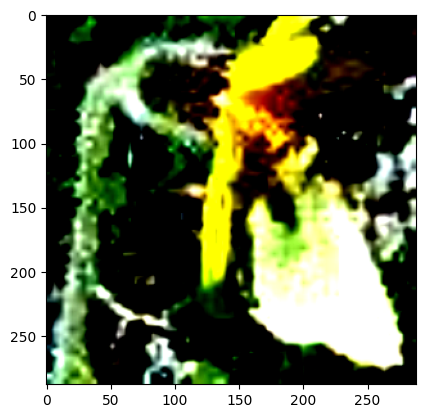

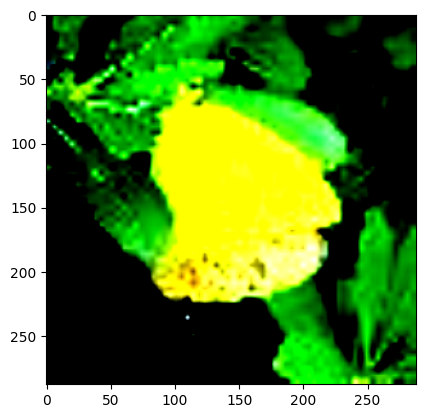

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

**Модель** (импорт предобученной сети)

In [ ]:
seed_everything(123456)

model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=200).to(device)
model_name = "efficientnet_b3"
model

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [ ]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth',
 'hf_hub_id': 'timm/efficientnet_b3.ra2_in1k',
 'architecture': 'efficientnet_b3',
 'tag': 'ra2_in1k',
 'custom_load': False,
 'input_size': (3, 288, 288),
 'test_input_size': (3, 320, 320),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (9, 9),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

**Тренировочный цикл**

In [ ]:
seed_everything(123456)

epochs = 3
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

for param in model.parameters():
  param.requires_grad = True

In [ ]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader):

    # wandb.init(
    #     project="02_CV_2",
    #     config={
    #         "epochs": epochs,
    #         "batch_size": batch_size,
    #         "device": device,
    #         "model_name": model_name,
    #         "augs": train_transform,
    #         "lr": learning_rate,
    #         "optimizer": optimizer
    #     }
    # )

    best_model = None
    best_loss = 1e3

    # Train
    for epoch in range(1, epochs + 1):

        print(f"\n[bold bright_white]Train epoch {epoch}/{epochs}[/bold bright_white]")   # для красоты

        train_loss = 0
        train_acc = 0

        for (inputs, labels) in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            _, preds = torch.max(output, 1)   # беру наиболее вероятный класс

            loss = criterion(output, labels)
            acc = torch.sum(preds == labels.data)   # считаю не accuracy в чистом виде, а просто количество верных ответов в батче (без усреднения)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * inputs.size(0)    # лосс также считаю неусредненную
            train_acc += acc.item()

        train_loss_per_epoch = train_loss / len(train_dataset)    # тут уже усредняю лосс и accuracy по всему датасету на эпохе
        train_accuracy_per_epoch = train_acc / len(train_dataset)

        print()

        # Validation
        val_loss = 0
        val_acc = 0

        print(f"[bold bright_white]Validation epoch {epoch}/{epochs} [/bold bright_white]")

        model.eval()
        with torch.no_grad():
          for (inputs, labels) in tqdm(val_dataloader):
              inputs = inputs.to(device)
              labels = labels.to(device)

              output = model(inputs)
              _, preds = torch.max(output, 1)

              loss = criterion(output, labels)
              acc = torch.sum(preds == labels.data)

              val_loss += loss.item() * inputs.size(0)
              val_acc += acc.item()

        val_loss_per_epoch = val_loss / len(val_dataset)
        val_accuracy_per_epoch = val_acc / len(val_dataset)

        # сохраняю лучшую модель
        if val_loss_per_epoch < best_loss:
              best_model = model
              best_loss = val_loss_per_epoch
              best_accuracy = val_accuracy_per_epoch
              torch.save(best_model, "best_model.pt")
              print()
              print(f"Сохранение лучшей модели с Accuracy = {val_accuracy_per_epoch}, Val_loss = {val_loss_per_epoch}")

        scheduler.step()

        # загружаю в wandb для сохранения эксперимента
        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": train_loss_per_epoch,
        #     "train_accuracy": train_accuracy_per_epoch,
        #     "val_loss": val_loss_per_epoch,
        #     "val_accuracy": val_accuracy_per_epoch,
        #     "best_loss": best_loss,
        #     "best_accuracy": best_accuracy,
        #     "lr": scheduler.get_last_lr()[-1]
        # })

        print()

        print(f"Epoch = [bold red]{epoch}/{epochs}[/bold red] | Train_loss = [bold yellow]{train_loss_per_epoch:.5f} [/bold yellow] \
    | Accuracy_train = [bold yellow]{train_accuracy_per_epoch:.5f}[/bold yellow] \
    | Val_loss = [bold green]{val_loss_per_epoch:.5f}[/bold green] | Accuracy_val = [bold green]{val_accuracy_per_epoch:.5f}[/bold green]")

In [ ]:
seed_everything(123456)

train(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Train epoch 1/3

  0%|          | 0/3125 [00:00<?, ?it/s]

Validation epoch 1/3 

  0%|          | 0/313 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.8338, Val_loss = 1.4678301122665405

Epoch = 1/3 | Train_loss = 2.09503      | Accuracy_train = 0.67887     | Val_loss = 1.46783 | Accuracy_val = 
0.83380

Train epoch 2/3

  0%|          | 0/3125 [00:00<?, ?it/s]

Validation epoch 2/3 

  0%|          | 0/313 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.839, Val_loss = 1.4099239542007447

Epoch = 2/3 | Train_loss = 1.40014      | Accuracy_train = 0.84082     | Val_loss = 1.40992 | Accuracy_val = 
0.83900

Train epoch 3/3

  0%|          | 0/3125 [00:00<?, ?it/s]

Validation epoch 3/3 

  0%|          | 0/313 [00:00<?, ?it/s]

Сохранение лучшей модели с Accuracy = 0.8531, Val_loss = 1.3523308980941773

Epoch = 3/3 | Train_loss = 1.15545      | Accuracy_train = 0.91362     | Val_loss = 1.35233 | Accuracy_val = 
0.85310

**Валидация результатов**

In [ ]:
model = torch.load("best_model.pt", map_location=torch.device(device))  # загрузка сохраненной модели

accuracy = evaluate_task(model, val_dataloader, val_dataset)
print(f"Accuracy {accuracy}")

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy 0.8531

#### Отчёт об экспериментах

In [ ]:
# отчет по п. 1 https://wandb.ai/alin30042003/02_CV_1/reports/02_CV-1--Vmlldzo5NjU2NTQy
# отчет по п. 2 https://wandb.ai/alin30042003/02_CV_2/reports/02_CV-2--Vmlldzo5NjU3NDk3